In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pandas import DataFrame
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings("ignore")

In [24]:
EPL = pd.read_csv('ranking.csv')

In [25]:
EPL
#YEAR: 리그 년도
#RANK: 리그 순위
#GF: 전체 득점 (GOALS FOR)
#GA: 전체 실점 (GOALS AGAINST)
#GD: 전체 득점-실점 (GOALS DIFFERENCE)
#WIN: 전체 승리
#DRAW: 전체 무승부
#LOSE: 전체 패배
#POINT: 승점
#EPL: EPL 우승 여부(yes: 우승, no: 우승 실패)
#UCL: 챔피언스리그 진출 여부(yes:진출 성공, no: 진출 실패)
#RELEGATION: 강등 여부 (yes: 강등, no: 잔류)

,YEAR,RANK,GF,GA,GD,WIN,DRAW,LOSE,POINT,EPL,UCL,RELEGATION
0,1995년,1,73,35,38,25,7,6,82,yes,yes,no
1,1995년,2,66,37,29,24,6,8,78,no,yes,no
2,1995년,3,70,34,36,20,11,7,71,no,yes,no
3,1995년,4,52,35,17,18,9,11,63,no,yes,no
4,1995년,5,49,32,17,17,12,9,63,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...
315,2010년,16,40,61,-21,9,15,14,42,no,no,no
316,2010년,17,46,66,-20,11,7,20,40,no,no,no
317,2010년,18,37,58,-21,8,15,15,39,no,no,yes
318,2010년,19,55,78,-23,10,9,19,39,no,no,yes


In [4]:
# 마지막으로 강등을 피하기 위한 조건을 알아내기 위해 classification을 통해 decision tree를 알아낼 것이다.

In [26]:
#전처리 과정
# classifying attribute로 득점, 실점, 승, 무, 패를 다루고 target attribute를 강등 여부로 정했기에 
# classification과 관련없는 attribute인 'YEAR','RANK','GD','POINT','EPL', 'UCL'는 제외할 것이다. 
EPL1=EPL.drop(['YEAR','RANK','GD','POINT','EPL','UCL'],axis=1,inplace=True)

In [27]:
EPL

,GF,GA,WIN,DRAW,LOSE,RELEGATION
0,73,35,25,7,6,no
1,66,37,24,6,8,no
2,70,34,20,11,7,no
3,52,35,18,9,11,no
4,49,32,17,12,9,no
...,...,...,...,...,...,...
315,40,61,9,15,14,no
316,46,66,11,7,20,no
317,37,58,8,15,15,yes
318,55,78,10,9,19,yes


In [28]:
EPL

,GF,GA,WIN,DRAW,LOSE,RELEGATION
0,73,35,25,7,6,no
1,66,37,24,6,8,no
2,70,34,20,11,7,no
3,52,35,18,9,11,no
4,49,32,17,12,9,no
...,...,...,...,...,...,...
315,40,61,9,15,14,no
316,46,66,11,7,20,no
317,37,58,8,15,15,yes
318,55,78,10,9,19,yes


In [29]:
epl_copy = EPL.copy()

In [30]:
epl_copy['GF']=pd.qcut(epl_copy['GF'],q=4,labels=['gfq1','gfq2','gfq3','gfq4'])
epl_copy['GA']=pd.qcut(epl_copy['GA'],q=4,labels=['gaq1','gaq2','gaq3','gaq4'])
epl_copy['WIN']=pd.qcut(epl_copy['WIN'],q=4,labels=['winq1','winq2','winq3','winq4'])
epl_copy['DRAW']=pd.qcut(epl_copy['DRAW'],q=4,labels=['drawq1','drawq2','drawq3','drawq4'])
epl_copy['LOSE']=pd.qcut(epl_copy['LOSE'],q=4,labels=['loseq1','loseq2','loseq3','loseq4'])

In [31]:
epl_copy

,GF,GA,WIN,DRAW,LOSE,RELEGATION
0,gfq4,gaq1,winq4,drawq1,loseq1,no
1,gfq4,gaq1,winq4,drawq1,loseq1,no
2,gfq4,gaq1,winq4,drawq3,loseq1,no
3,gfq3,gaq1,winq4,drawq2,loseq2,no
4,gfq3,gaq1,winq3,drawq3,loseq1,no
...,...,...,...,...,...,...
315,gfq1,gaq4,winq1,drawq4,loseq2,no
316,gfq2,gaq4,winq2,drawq1,loseq4,no
317,gfq1,gaq4,winq1,drawq4,loseq2,yes
318,gfq3,gaq4,winq1,drawq2,loseq4,yes


In [32]:
eplvalue = epl_copy.values.tolist()

In [33]:
eplvalue

[['gfq4', 'gaq1', 'winq4', 'drawq1', 'loseq1', 'no'],
 ['gfq4', 'gaq1', 'winq4', 'drawq1', 'loseq1', 'no'],
 ['gfq4', 'gaq1', 'winq4', 'drawq3', 'loseq1', 'no'],
 ['gfq3', 'gaq1', 'winq4', 'drawq2', 'loseq2', 'no'],
 ['gfq3', 'gaq1', 'winq3', 'drawq3', 'loseq1', 'no'],
 ['gfq4', 'gaq2', 'winq3', 'drawq2', 'loseq2', 'no'],
 ['gfq4', 'gaq2', 'winq4', 'drawq1', 'loseq4', 'no'],
 ['gfq3', 'gaq1', 'winq3', 'drawq4', 'loseq1', 'no'],
 ['gfq3', 'gaq3', 'winq3', 'drawq4', 'loseq1', 'no'],
 ['gfq2', 'gaq3', 'winq3', 'drawq2', 'loseq2', 'no'],
 ['gfq2', 'gaq2', 'winq2', 'drawq4', 'loseq2', 'no'],
 ['gfq1', 'gaq2', 'winq2', 'drawq2', 'loseq3', 'no'],
 ['gfq1', 'gaq3', 'winq2', 'drawq1', 'loseq4', 'no'],
 ['gfq3', 'gaq4', 'winq1', 'drawq3', 'loseq3', 'no'],
 ['gfq3', 'gaq4', 'winq1', 'drawq2', 'loseq3', 'no'],
 ['gfq2', 'gaq4', 'winq1', 'drawq4', 'loseq3', 'no'],
 ['gfq1', 'gaq3', 'winq1', 'drawq3', 'loseq3', 'no'],
 ['gfq1', 'gaq4', 'winq1', 'drawq3', 'loseq3', 'yes'],
 ['gfq1', 'gaq3', 'winq1', 

In [36]:
te = TransactionEncoder()
te_ary = te.fit(eplvalue).transform(eplvalue)
te_ary.astype('int')

array([[1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1]])

In [39]:
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)

frequent_itemsets

,support,itemsets
0,0.309375,(drawq1)
1,0.250000,(drawq2)
2,0.237500,(drawq3)
3,0.203125,(drawq4)
4,0.262500,(gaq1)
...,...,...
103,0.156250,"(gfq4, gaq1, winq4, no)"
104,0.171875,"(loseq1, gaq1, winq4, no)"
105,0.103125,"(gaq4, loseq4, winq1, yes)"
106,0.171875,"(gfq4, loseq1, winq4, no)"


In [47]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(drawq1),(gaq1),0.309375,0.262500,0.10625,0.343434,1.308321,0.025039,1.123269
1,(gaq1),(drawq1),0.262500,0.309375,0.10625,0.404762,1.308321,0.025039,1.160250
2,(gfq4),(drawq1),0.231250,0.309375,0.10625,0.459459,1.485121,0.034707,1.277656
3,(drawq1),(gfq4),0.309375,0.231250,0.10625,0.343434,1.485121,0.034707,1.170865
4,(drawq1),(no),0.309375,0.850000,0.26250,0.848485,0.998217,-0.000469,0.990000
...,...,...,...,...,...,...,...,...,...
395,(gfq4),"(loseq1, gaq1, winq4, no)",0.231250,0.171875,0.15000,0.648649,3.773956,0.110254,2.356971
396,(gaq1),"(gfq4, loseq1, winq4, no)",0.262500,0.171875,0.15000,0.571429,3.324675,0.104883,1.932292
397,(no),"(gfq4, loseq1, gaq1, winq4)",0.850000,0.150000,0.15000,0.176471,1.176471,0.022500,1.032143
398,(loseq1),"(gfq4, gaq1, winq4, no)",0.256250,0.156250,0.15000,0.585366,3.746341,0.109961,2.034926


In [49]:
rules = association_rules(frequent_itemsets, metric='support', min_threshold = 0.1)
rules[rules['consequents'] == {'yes'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
42,(gaq4),(yes),0.250000,0.15,0.128125,0.512500,3.416667,0.090625,1.743590
50,(gfq1),(yes),0.250000,0.15,0.100000,0.400000,2.666667,0.062500,1.416667
86,(loseq4),(yes),0.181250,0.15,0.115625,0.637931,4.252874,0.088438,2.347619
96,(winq1),(yes),0.296875,0.15,0.150000,0.505263,3.368421,0.105469,1.718085
182,"(gaq4, loseq4)",(yes),0.140625,0.15,0.103125,0.733333,4.888889,0.082031,3.187500
188,"(gaq4, winq1)",(yes),0.193750,0.15,0.128125,0.661290,4.408602,0.099062,2.509524
200,"(gfq1, winq1)",(yes),0.181250,0.15,0.100000,0.551724,3.678161,0.072813,1.896154
266,"(loseq4, winq1)",(yes),0.150000,0.15,0.115625,0.770833,5.138889,0.093125,3.709091
342,"(gaq4, loseq4, winq1)",(yes),0.131250,0.15,0.103125,0.785714,5.238095,0.083437,3.966667


In [7]:
#classification을 위해 training data와 test data를 7:3의 비율로 나누었다.
feature_cols = ['GF', 'GA', 'WIN', 'DRAW', 'LOSE']

X = EPL[feature_cols]
y = EPL.RELEGATION

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=100)

In [8]:
#decision tree 기법을 사용하기 위해서는 어떤 attribute를 기준으로 몇번 분화를 하는지를 결정해야 한다.
#어떤 attribute를 기준으로 몇번 분화를 하는지를 결정하기 위해서는 information gain, gini index등의 classifier값을 구해서 그 classifier값이 큰 것 순으로 분화를 한다.
# 어떤 classifier값을 사용할지를 지금 구할 것이다.

In [9]:
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': list(range(2, 16)),
    'min_samples_leaf': list(range(1, 6)),
    'min_samples_split': list(range(2, 6)),
    'random_state':[10]
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1, cv=5)

In [10]:
%time clf.fit(X_train, y_train)

Wall time: 10.9 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'random_state': [10]})

In [11]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 10}

In [12]:
#clf.best_params_를 통해서
#gini를 기준으로 2번 분화하는 게 가장 적절하다는 결과값이 나온다.

In [13]:
my_model = clf.best_estimator_
my_model.fit(X_train, y_train)
my_model_score_train = my_model.score(X_train, y_train)
my_model_score_test = my_model.score(X_test, y_test)

print(clf.best_estimator_)
print('Training data의 accuracy = ',my_model_score_train)
print('Testing data의 accuracy = ',my_model_score_test)

DecisionTreeClassifier(max_depth=2, random_state=10)
Training data의 accuracy =  0.9508928571428571
Testing data의 accuracy =  0.9791666666666666


In [14]:
#그러면 gini index를 기준으로 attribute의 중요도를 구할 것이다.

features = pd.DataFrame(X.columns.tolist())
features.columns = ['Features']
fi = pd.DataFrame(my_model.feature_importances_)
fi.columns = ['Value']
fea_imp = pd.concat([features, fi], axis=1)
fea_imp.sort_values(by='Value', ascending = False)

,Features,Value
2,WIN,0.80419
4,LOSE,0.19581
0,GF,0.00000
1,GA,0.00000
3,DRAW,0.00000


In [15]:
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=2, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=1)

In [16]:
#decision tree의 대략적인 모양을 만들었다.

from sklearn import tree
text_representation = tree.export_text(treeclf)
print(text_representation)

#feature_0: 득점(GF)
#feature_1: 실점(GA)
#feature_2: 승(WIN)
#feature_3: 무(DRAW)
#feature_4: 패(LOSE)

|--- feature_2 <= 8.50
|   |--- feature_4 <= 16.50
|   |   |--- class: no
|   |--- feature_4 >  16.50
|   |   |--- class: yes
|--- feature_2 >  8.50
|   |--- feature_4 <= 21.50
|   |   |--- class: no
|   |--- feature_4 >  21.50
|   |   |--- class: yes



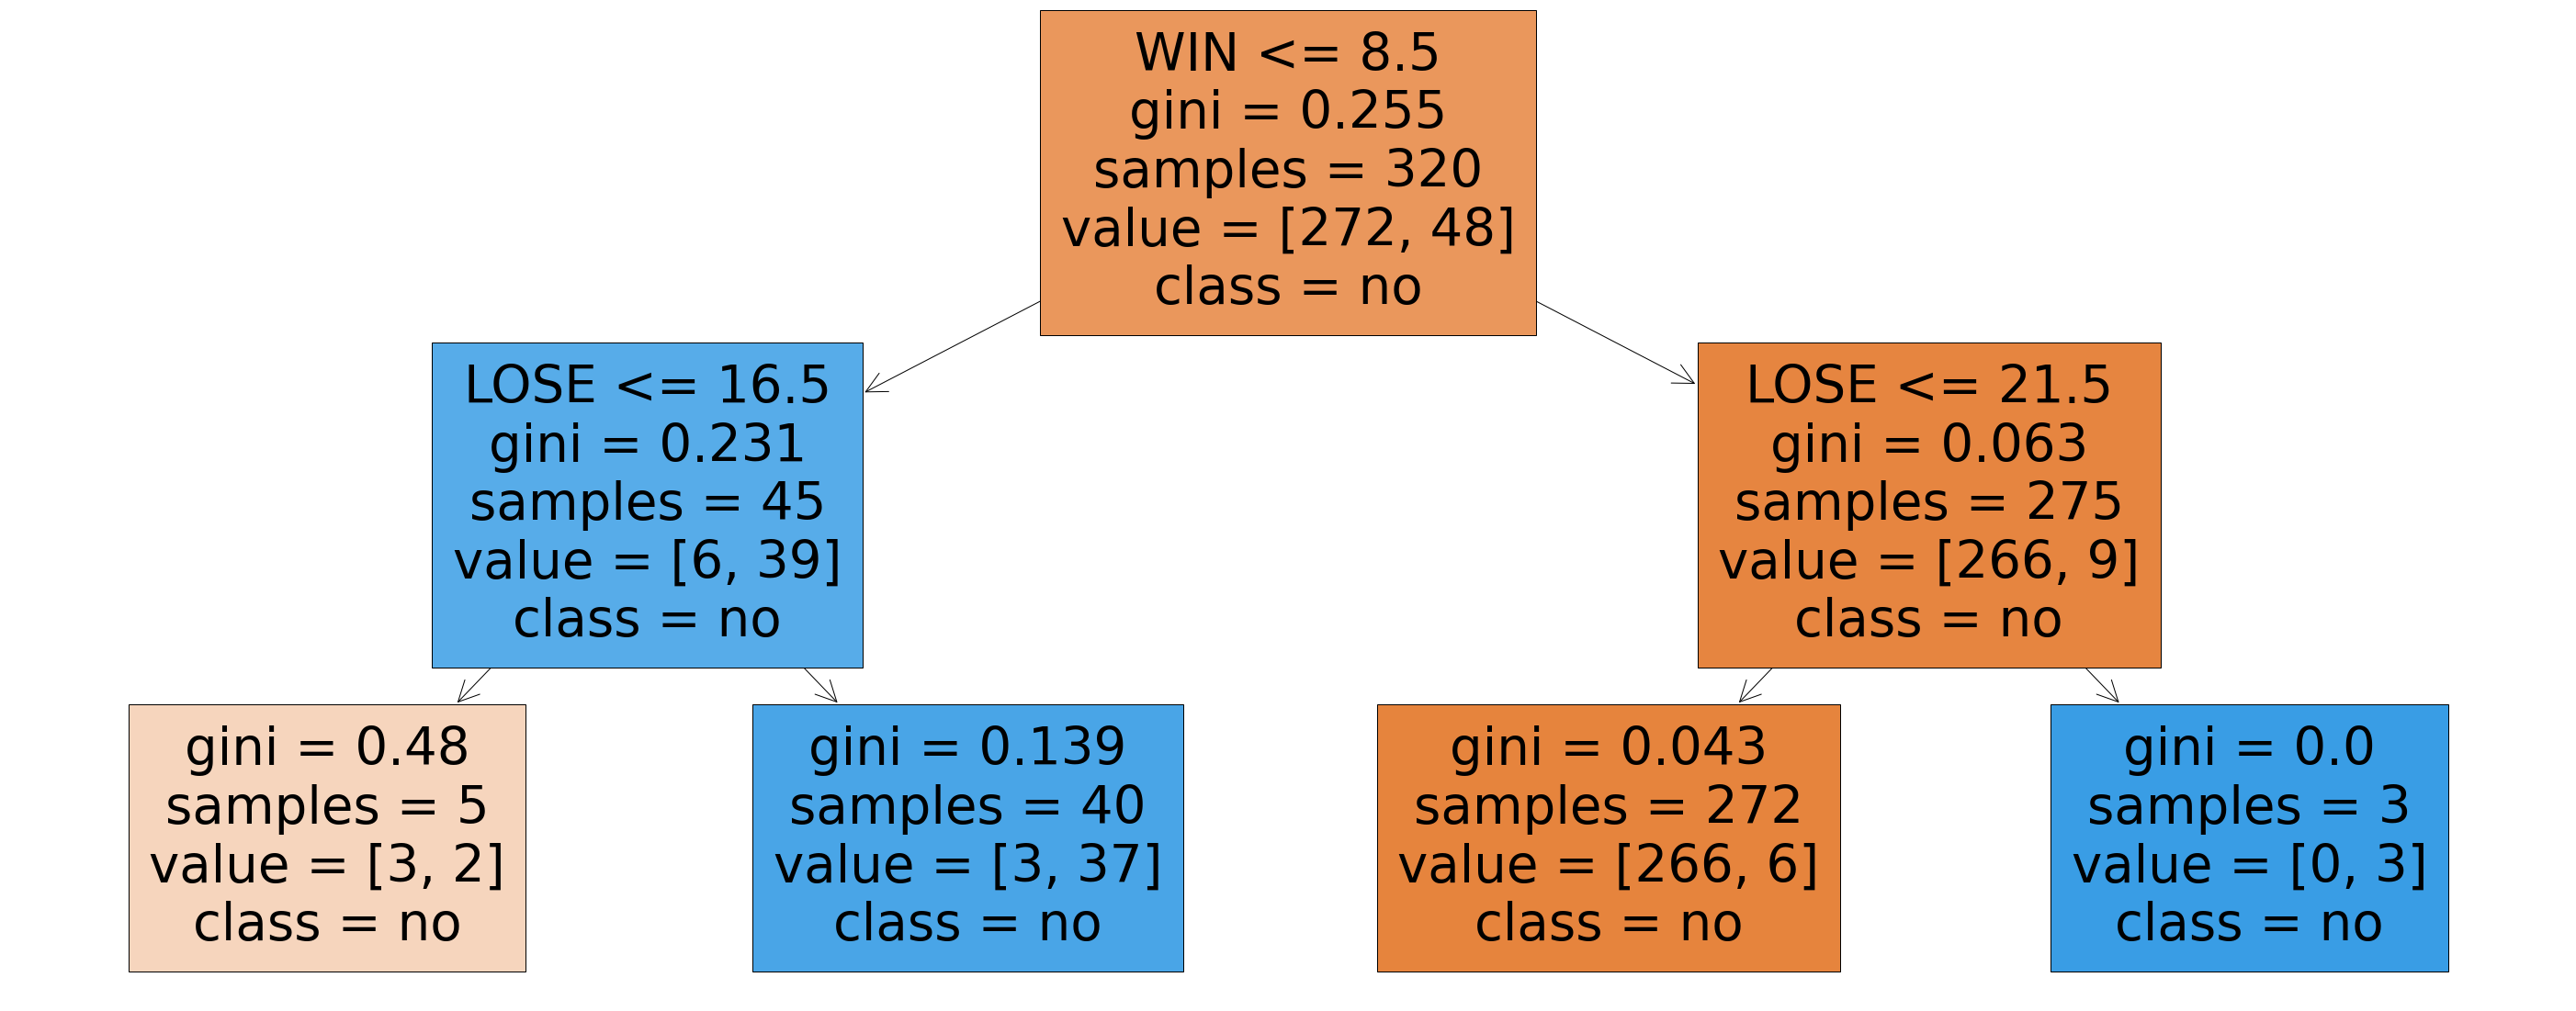

In [17]:
#이제 제대로 된 decision tree를 만들 것이다.
with open("decision_tree.log", "w") as fout:
    fout.write(text_representation)
fig = plt.figure(figsize=(50,20))
_ = tree.plot_tree(treeclf, 
                   feature_names=feature_cols,  
                   class_names=EPL.RELEGATION.astype(str),
                   filled=True)

In [18]:
#1.승리 8.5번 이하, 패배 16.5번 이하-강등 X
#2.승리 8.5번 이하, 패배 16.5번 초과-강등
#3.승리 8.5번 초과, 패배 21.5번 이하-강등 X
#4.승리 8.5번 초과, 패배 21.5번 초과-강등 